# XGBoost
- GBM 기반의 알고리즘
- 따라서 경사하강법을 사용한다

- 장점

   1. 분류와 회귀에서 뛰어난 예측 성능(CART 기반)
   2. GBM대비 빠른 수행시간 (다른 머신러닝 (랜덤포레스트 등) 에 비해 빠른 것은 아님)
   3. 과적합 방지가 가능한 규제 포함
   4. 나무 가지치기 => 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄일 수 있음
   5. 자체 내장된 교차 검증
   6. 결손값 자체 처리
   7. 조기 중단
   8. 병렬처리 가능

## 중요 파라미터 - 예측에 지대한 영향
----------------
> n_estimators [default = 100] (@@@)

- 나무의 개수
- LGBM의 경우 1000개 이상 정도로 하는 것이 바람직하나 그 수가 너무 클수록 과적합 가능성 존재
----------------
> learning_rate [default = 0.1] (@@@)

- 학습 단계별로 가중치를 얼만큼 사용할지 결정/ 이전의 결과를 얼마나 반영할건지
- 일반적으로 n_estimator를 크게, learning_rate를 작게하여 성능을 향상시킬 수 있으나 시간이 길어지는 영향 고려   
- 0.05~0.1 정도로 맞추고 그 이상이면 다른 파라미터들을 튜닝할때 편. 미세한 정확도 조정을 원하면 더 작게 둬서 마른걸레를 빤다.
----------------
> max_depth [default = -1](제한없이 분기) (@@@)

- 모델 과적합을 다룰 때 사용. 만약 과적합된 것 같다고 느끼신다면 max_depth 값을 줄일 것
----------------
> booster (@@@)

- 어떤 부스터 구조를 쓸지 결정
- gbtree / gblinear / dart
----------------
> eval_metric[default - 회귀 : rmse, 분류 : error] (@@@)

- 검증에 사용되는 함수 정의
- eval_set : 성능 평가를 수행할 데이터 세트

      1) rmse : root mean square error
      2) mae : mean absolute error
      3) logloss : negative log-likelihood
      4) error : binary classificaion error rate (임계값 0.5)
      5) merror : multiclass classification error rate
      6) mlogloss : multiclass logloss
      7) auc : area under the curve

----------------

## 파라미터 - 정밀한 튜닝
----------------
> early_stopping_rounds (@@)

- 최대한 몇 개의 트리를 완성해볼 것인지 valid loss에 더이상 진전이 없으면 멈춤
- 과적합을 방지할 수 있음, n_estimators 가 높을때 주로 사용
----------------
> subsample [default = 1] (@@)

- 각 트리마다 데이터 샘플링 비율
- over-fitting 방지(일반적으로 0.5 ~ 1)
----------------
> colsample_bytree [default = 1] (@@)

- 각 트리마다 컬럼 샘플링 비율(일반적으로 0.5 ~ 1)
- 0.7~0.9 정도로 세팅하는 편이 일반적


----------------

## 파라미터 - Default 값을 추천

> nthread (@)

- 몇개의 쓰레드를 동시에 처리하도록 할지 결정(default는 최대한 많이)
----------------
> num_feature (@)

- feature 차원의 숫자를 정해야 하는 경우 옵션 세팅(default는 최대한 많이)
----------------
> min_child_weight [default = 1] (@)

- child 에서 필요한 모든 관측치에 대한 가중치의 최소 합
- 이 값보다 샘플 수가 작으면 leaf node가 되는 것
- 너무 크면 under-fitting 될 수 있음
----------------
> gamma [default = 0] (@)

- 트리에서 추가적으로 가지를 나눌지를 결정할 최소 손실 감소 값
- 값이 클수록 과적합 감소 효과
----------------
> reg_lambda [default = 1] (@) 

- L2 regularization(ex. 릿지) 가중치(클수록 보수적) 
----------------
> reg_alpha [default = 0] (@)

- L1 regularization(ex. 라쏘) 가중치(클수록 보수적)
- 특성이 매우 많은때 사용해볼만 함
----------------
> scale_pos_weight [default = 1] (@)

- 데이터가 불균형할때 사용, 0보다 큰 값
- 보통 값을 음성 데이터 수/ 양성 데이터 수 값으로 함
----------------      
> objective [default = reg:linear] (@) (목적 함수)

      1) binary:logistic :이진 분류를 위한 로지스틱 회귀, 클래스가 아닌 예측된 확률 반환
      2) reg : linear : 회귀모형
      3) multi:softmax : softmax를 사용한 다중 클래스 분류, 확률이 아닌 예측된 클래스 반환
      4) multi:softprob : softmax와 같지만 각 클래스에 대한 예상 확률 반환
      5) ...

In [13]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from xgboost import plot_importance
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset= load_breast_cancer()
X_feature = dataset.data
y_label = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_label, test_size=0.2, random_state=156)

In [4]:
def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('-'*30)
    print('Accuracy : {0:.4f} / Precision : {1:.4f} / Recall : {2:.4f} / F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

In [5]:
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
pred = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred)

[21:44:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
오차행렬
[[35  2]
 [ 1 76]]
------------------------------
Accuracy : 0.9737 / Precision : 0.9744 / Recall : 0.9870 / F1 : 0.9806


## 파라미터 조정을 통한 모델 출력

In [6]:
evals = [(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train,
               early_stopping_rounds = 100,  # 100개 진행했을 때 성능 평가 지수가 향상되지 않으면 조기종료
               eval_metric = 'logloss',      # 검증에 사용되는 함수 정의
               eval_set = evals,             # 성능 평가를 수행할 데이터 세트
               verbose = 1)                  # 0 : 표시 x / 1 : 자세히 / 2 : 간략히
ws100_pred = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

C:\Users\Park\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[290]	validation_0-logloss:0.08645
[291]	validation_0-logloss:0.08632
[292]	validation_0-logloss:0.08628
[293]	validation_0-logloss:0.08615
[294]	validation_0-logloss:0.08620
[295]	validation_0-logloss:0.08622
[296]	validation_0-logloss:0.08631
[297]	validation_0-logloss:0.08618
[298]	validation_0-logloss:0.08626
[299]	validation_0-logloss:0.08613
[300]	validation_0-logloss:0.08618
[301]	validation_0-logloss:0.08605
[302]	validation_0-logloss:0.08602
[303]	validation_0-logloss:0.08610
[304]	validation_0-logloss:0.08598
[305]	validation_0-logloss:0.08606
[306]	validation_0-logloss:0.08597
[307]	validation_0-logloss:0.08600
[308]	validation_0-logloss:0.08600
[309]	validation_0-logloss:0.08588
[310]	validation_0-logloss:0.08592


In [7]:
get_clf_eval(y_test, ws100_pred)

오차행렬
[[34  3]
 [ 1 76]]
------------------------------
Accuracy : 0.9649 / Precision : 0.9620 / Recall : 0.9870 / F1 : 0.9744


In [8]:
# 조기종료 값을 낮추어 진행
# 조기종료 값을 낮출 경우 충분한 학습의 저하로 성능이 저하될 수 있다.

xgb_wrapper.fit(X_train, y_train,
               early_stopping_rounds = 10,  
               eval_metric = 'logloss',     
               eval_set = evals,             
               verbose = 1)                  
ws10_pred = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]    # 1로 분류가 될 확률을 출력한다.

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

C:\Users\Park\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [9]:
get_clf_eval(y_test, ws10_pred)

오차행렬
[[34  3]
 [ 2 75]]
------------------------------
Accuracy : 0.9561 / Precision : 0.9615 / Recall : 0.9740 / F1 : 0.9677


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

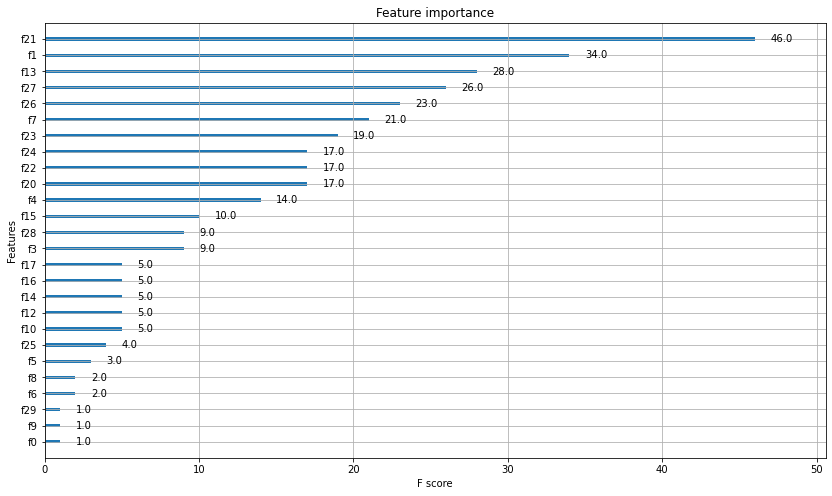

In [14]:
fig, ax = plt.subplots(figsize = (14,8))
plot_importance(xgb_wrapper, ax= ax)